In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score,f1_score,matthews_corrcoef,precision_score
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.utils import resample


In [2]:
df = pd.read_csv("./wdbc.data",header=None)

In [3]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


### Encoding and creating a train/test split of the breast cancer wisconsin dataset

In [4]:
le = LabelEncoder()

x = df.iloc[:,2:]
y = le.fit_transform(df.iloc[:,1])

In [5]:
#check the LabelEncoder classes
print(le.classes_)
print(le.transform(['B','M']))

['B' 'M']
[0 1]


In [6]:
x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size=0.2,
                                                 random_state=1,
                                                 stratify=y)

### make_pipeline in sklearn for StandardScalar(), PCA and logistic regression

In [7]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(x_train,y_train)

y_pred = pipe_lr.predict(x_test)
test_acc = pipe_lr.score(x_test,y_test)

print(f"Test dataset accuracy =: {round(test_acc,3)}")
print('')
print('--------------CONFUSION MATRIX--------------')
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))

Test dataset accuracy =: 0.956

--------------CONFUSION MATRIX--------------
Predicted   0   1
Actual           
0          71   1
1           4  38


## stratified kfold method for model selection

In [8]:
kfold = StratifiedKFold(n_splits=10).split(x_train,y_train)
scores = []

for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(x_train.iloc[train], y_train[train])    # must use .iloc for the x_train set since it is a pandas dataframe
    score = pipe_lr.score(x_train.iloc[test],y_train[test])  # must use .iloc for the x_train set since it is a pandas dataframe
    scores.append(score)
    print(f"fold:{k+1: 02d}," f" Class distribution: {np.bincount(y_train[train])}," f" Accuracy: {score: .3f}")

fold: 1, Class distribution: [256 153], Accuracy:  0.935
fold: 2, Class distribution: [256 153], Accuracy:  0.935
fold: 3, Class distribution: [256 153], Accuracy:  0.957
fold: 4, Class distribution: [256 153], Accuracy:  0.957
fold: 5, Class distribution: [256 153], Accuracy:  0.935
fold: 6, Class distribution: [257 153], Accuracy:  0.956
fold: 7, Class distribution: [257 153], Accuracy:  0.978
fold: 8, Class distribution: [257 153], Accuracy:  0.933
fold: 9, Class distribution: [257 153], Accuracy:  0.956
fold: 10, Class distribution: [257 153], Accuracy:  0.956


In [9]:
#### using stratified kfold from sklearn

scores = cross_val_score(estimator=pipe_lr,
                         X=x_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1) # sets the CPU's to evaluate performance.  If -1, all available CPU's will be used

scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

In [10]:
print(round(scores.mean(),3),'+/-', round(scores.std(),4))

0.95 +/- 0.0139


In [11]:
round(scores.std(),4)

np.float64(0.0139)

## Learning Curve function in sklearn

In [12]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',max_iter=10000))

In [13]:
# NOTE: the learning curve function uses stratified kfold cv by default.  Here, cv is set to 10 folds.
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                      X=x_train,
                                                      y=y_train,
                                                      train_sizes=np.linspace(0.1,1,10),
                                                      cv=10,n_jobs=1)

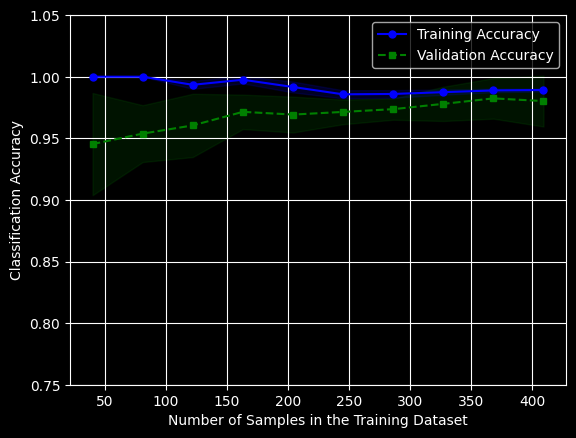

In [14]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

# plotting the learning curve
plt.plot(train_sizes,train_mean,color = 'blue',marker='o',markersize=5,label='Training Accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='Validation Accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of Samples in the Training Dataset')
plt.ylabel('Classification Accuracy')
plt.legend(loc='best')
plt.ylim([0.75,1.05])
plt.show()


In [15]:
# NOTE: in the above plot, it is noted that model performs well on both the training and validation datasets when the model has 250 samples or more in the trainign data.
# It is also seen that the accuracy of the training data increases when there are less than 250 samples and the accuracy diverges between training and validation, indicating overfitting on the limited data.

## Adressing over/underfitting with validation curves

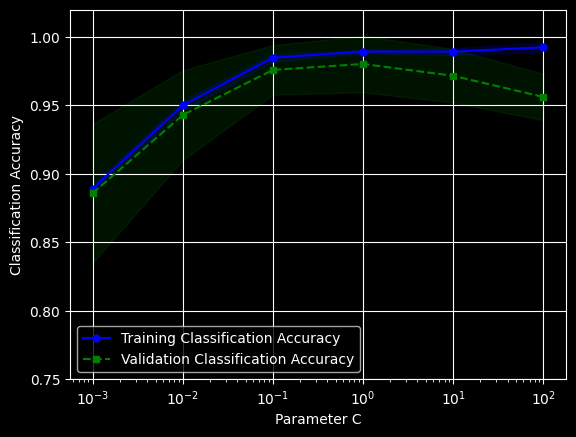

In [16]:
parameter_range = [0.001,0.01,0.1,1.0,10.0,100.0]

train_scores,test_scores = validation_curve(estimator=pipe_lr,
                                            X=x_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=parameter_range,
                                            cv=10)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

# plotting the validation curve
plt.plot(parameter_range,train_mean,color='blue',marker='o',markersize=5,label='Training Classification Accuracy')
plt.fill_between(parameter_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')

plt.plot(parameter_range,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='Validation Classification Accuracy')
plt.fill_between(parameter_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Classification Accuracy')
plt.ylim([0.75,1.02])
plt.show()

In [17]:
#NOTE: validation curve plot also uses stratified kfold cross validaton by default
# notice that the model underfits both the training and validation data with an increased regularization strength (small values of C)
# notice that the accuracy diverges when C starts to get large (decreased regularization strength).  This shows the model is starting to overfit the data
# Sweet spot for the C parameter is somewhere between 0.1 and 1.0

## Hyperparameter tuning using GridsearchCV

In [18]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

parameter_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

param_grid = [{'svc__C':parameter_range,
               'svc__kernel':['linear']},
               {'svc__C':parameter_range,
                'svc__gamma':parameter_range,
                'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=1)

gs = gs.fit(x_train,y_train)

In [19]:
print(gs.best_score_)
print('')
print(gs.best_params_)

0.9846859903381642

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [20]:
# refitting the best model parameters from the grid search on the whole training dataset
clf = gs.best_estimator_
clf.fit(x_train,y_train)

print(f"Accuracy on the Test Dataset: {clf.score(x_test,y_test): .3f}")

Accuracy on the Test Dataset:  0.974


## Randomized Search (instead of using GridSearch)

In [21]:
#NOTE: using loguniform ensures a uniform distribution of samples within the given range.  This ensures enough samples to choose from in a range of values
param_range = scipy.stats.loguniform(0.0001,1000.0)

np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [22]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1, probability=True))

param_grid = [{'svc__C':param_range, 'svc__kernel': ['linear']},
              {'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,random_state=1,
                        n_jobs= -1)

rs = rs.fit(x_train,y_train)

In [23]:
print(rs.best_score_)
print('')
print(rs.best_params_)

0.9780676328502416

{'svc__C': np.float64(0.05971247755848463), 'svc__kernel': 'linear'}


In [24]:
print(f"Classification accuracy on the test dataset: {rs.score(x_test,y_test): .3f}")

Classification accuracy on the test dataset:  0.974


## Nested Cross validation with grid search to assess performance between models

In [25]:
# model1 - svm with nested cross validation
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},
              {'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs,x_train,y_train,scoring='accuracy',cv=5)

print(f"CV Accuracy: {np.mean(scores): .3f}" f" +/- {np.std(scores): .3f}")

CV Accuracy:  0.974 +/-  0.015


In [26]:
# model2 - decision tree classifier
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs,x_train,y_train,scoring='accuracy',cv=5)


print(f"CV Accuracy: {np.mean(scores): .3f}" f" +/- {np.std(scores): .3f}")

CV Accuracy:  0.934 +/-  0.016


## Model Evaluation - CM, precision, recall, F1 Score, Matthews correlation coefficient (MCC)

In [27]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(x_train,y_train)

y_pred = pipe_svc.predict(x_test)

cm = confusion_matrix(y_true=y_test,y_pred=y_pred)

print(cm)

[[71  1]
 [ 2 40]]


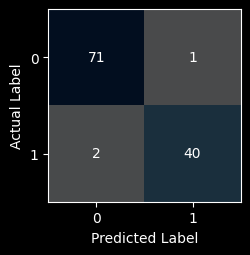

In [28]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)

for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
        ax.text(x=j,y=i,s=cm[i,j],
                va='center',ha='center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [29]:
precision_score(y_true=y_test,y_pred=y_pred)

0.975609756097561

In [30]:
recall_score(y_true=y_test,y_pred=y_pred)

0.9523809523809523

In [31]:
f1_score(y_true=y_test,y_pred=y_pred)

0.963855421686747

In [32]:
matthews_corrcoef(y_true=y_test,y_pred=y_pred)

0.9433397594898876

### ROC/AUC plot example from book (using the different folds)

C:\Users\chris\AppData\Local\Temp\ipykernel_18176\599726727.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(mean_fpr,mean_tpr,'k--',label=f"Mean ROC (area = {mean_auc: .2f})", lw=2, color='blue')


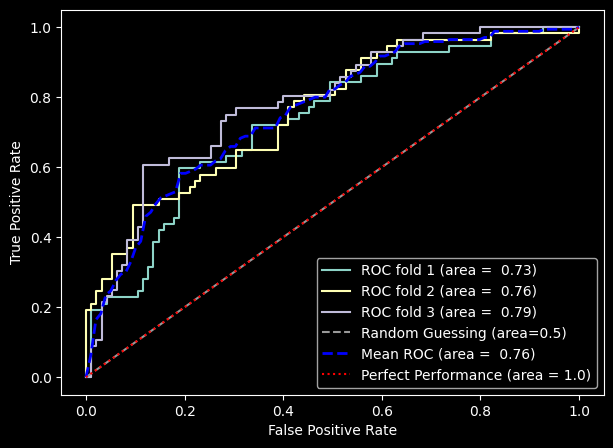

In [33]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2',random_state=1,solver='lbfgs',C=100.0)      
                        )

x_train2 = x_train.iloc[:,[4,14]]

cv = list(StratifiedKFold(n_splits=3).split(x_train,y_train))

fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(
        x_train2.iloc[train],
        y_train[train]
    ).predict_proba(x_train2.iloc[test])
    fpr,tpr,thresholds = roc_curve(y_train[test],
                                   probas[:,1],
                                   pos_label=1)
    mean_tpr += interp(mean_fpr,fpr,tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f"ROC fold {i+1} (area = {roc_auc: .2f})")

plt.plot([0,1],[0,1],linestyle = '--',color=(0.6,0.6,0.6),label='Random Guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',label=f"Mean ROC (area = {mean_auc: .2f})", lw=2, color='blue')
plt.plot([0,0,1],[0,0,1], linestyle=':',color='red',label="Perfect Performance (area = 1.0)")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### ROC/AUC curve (Best model was the SVM.  Use that model witht he best parameters from the grid search, refit, and create the curves)

In [34]:
stdsc = StandardScaler()
x_train_std = stdsc.fit_transform(x_train)
x_test_std = stdsc.fit_transform(x_test)

In [35]:
svm = SVC(C=100.0,
          gamma=0.001,
          kernel='rbf',
          random_state=1,
          probability=True)

svm.fit(x_train_std,y_train)

,C,100.0
,kernel,'rbf'
,degree,3
,gamma,0.001
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [36]:
test_pred = svm.predict(x_test_std)
pd.crosstab(y_test,test_pred,rownames=['Actual'],colnames=['Predicted'])

Predicted,0,1
Actual,,
0,70,2
1,1,41


In [37]:
cm = confusion_matrix(y_true=y_test,y_pred=test_pred)


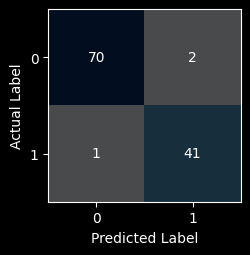

In [38]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)

for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
        ax.text(x=j,y=i,s=cm[i,j],
                va='center',ha='center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [39]:
y_train_proba = svm.predict_proba(x_train_std)[:, 1]
y_test_proba = svm.predict_proba(x_test_std)[:, 1]

In [40]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba,pos_label=1)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba,pos_label=1)

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

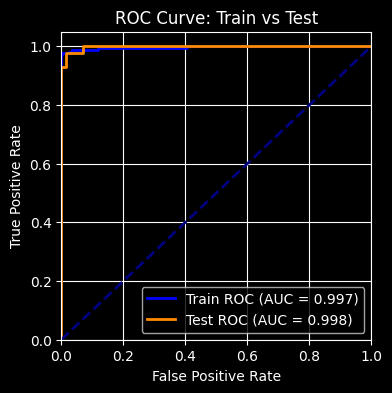

In [41]:
plt.figure(figsize=(4, 4))

plt.plot(fpr_train, tpr_train, color="blue", lw=2,
         label=f"Train ROC (AUC = {auc_train:.3f})")

plt.plot(fpr_test, tpr_test, color="darkorange", lw=2,
         label=f"Test ROC (AUC = {auc_test:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Train vs Test")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### the above plot looks odd, but could be possible considering the high degree of classification accuracy.  This is abnormal in real world datasets.  AUC's in the .75 range would be considered pretty good.

##### Also see notes in book about how to deal with multiclass problems when plotting AUC, F1, recall and other metrics as the above example is just for binary classification

## Dealing with class imbalance - sampling example

In [42]:
x_imb = np.vstack((x[y==0],x[y==1][:40]))
y_imb = np.hstack((y[y==0],y[y==1][:40]))

In [43]:
y_imb.mean() ## note with the above resampling, we created a new dataset where the binary classification is highly imbalanced (10% are positive cases)

np.float64(0.10075566750629723)

In [44]:
print(f"Number of positive cases before upsampling: {y_imb[y_imb==1].sum()}")

Number of positive cases before upsampling: 40


In [45]:
x_upsampled,y_upsampled = resample(
    x_imb[y_imb==1],
    y_imb[y_imb==1],
    replace=True,
    n_samples=x_imb[y_imb==0].shape[0],
    random_state=123
)

In [46]:
x_balanced = np.vstack((x[y==0],x_upsampled))
y_balanced = np.hstack((y[y==0],y_upsampled))

In [47]:
print(f"Number of class 0's after upsampling: {y_balanced[y_balanced==0].shape[0]}")
print(f"Number of class 1's after upsampling: {y_balanced[y_balanced==1].shape[0]}")

Number of class 0's after upsampling: 357
Number of class 1's after upsampling: 357


In [48]:
pd.DataFrame(y_balanced).value_counts()

0
0    357
1    357
Name: count, dtype: int64